% Video Object Detection #
# import

In [1]:
import cv2
print(cv2.__version__)
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from numba import jit

4.1.0


# File selection

In [2]:
path = "/Users/oliviermanette/Desktop/trailer detection challenge/data/P473_Arizona_Day_Asphalt_Close_To_Sunset_dry_Nominal_8300lx"
os.chdir(path)

In [3]:
pwd

'/Users/oliviermanette/Desktop/trailer detection challenge/data/P473_Arizona_Day_Asphalt_Close_To_Sunset_dry_Nominal_8300lx'

In [4]:
ls

P473_Arizona_Day_Asphalt_Close_To_Sunset_dry_Nominal_8300lx.avi*
P473_Arizona_Day_Asphalt_Close_To_Sunset_dry_Nominal_8300lx.dat_GT.csv*


In [5]:
#fileName='W420_ES_Hi_Snow_Slush_Asphalt_28klux.avi'
fileName = 'P473_Arizona_Day_Asphalt_Close_To_Sunset_dry_Nominal_8300lx.avi'

# Test Video Loop

In [6]:
cap = cv2.VideoCapture(fileName)  # load the video
while (cap.isOpened()):  # play the video by reading frame by frame
    ret, frame = cap.read()
    if ret == True:
        # optional: do some image processing here
        cv2.imshow('frame', frame)
        # show the video
        if cv2.waitKey(1) & 0xFF == ord('q'):
            #if 0xFF == ord('q'):
            break
    else:
        break
cap.release()
cv2.destroyAllWindows()

# Variables globales
Pour des raisons de lisibilité du code, l'ensemble des variables locales seront précédés du préfixe 'l' afin de les différencier des variables globales qui n'ont pas de préfixe.
## Type de données de position

In [7]:
posType = np.dtype([('x', 'u1'), ('y', 'u2')])

## Type de données de Neurones

In [8]:
NeuronType = np.dtype([('longueur', 'u1'), ('angle', 'f4'), ('weight', 'f4'),
                       ('precision', 'f4'), ('xPos', 'u1'), ('yPos', 'u2'),
                       ('group', 'u1'), ('layer', 'u1')])

## Taille des champs récepteurs neuronaux

In [9]:
tailleField = 7

# Fonctions
## Calcul d'un neurone champ moyen
A partir d'une liste de neurones, il retourne le neurone moyen

In [10]:
def getAvgFieldNeuron(lNeuronList, typeList=NeuronType):
    lNeurons = np.zeros(1, dtype=typeList)
    lpNeurons = pd.DataFrame(lNeurons)
    lpNeurons['longueur'] = int(lNeuronList.longueur[0:1])
    lpNeurons['angle'] = float(
        np.sum((lNeuronList.angle * lNeuronList.weight) /
               np.sum(lNeuronList.weight)))
    lpNeurons['weight'] = float(
        np.sum((lNeuronList.weight * lNeuronList.weight) /
               np.sum(lNeuronList.weight)))
    lpNeurons['precision'] = float(
        np.sum((lNeuronList.precision * lNeuronList.weight) /
               np.sum(lNeuronList.weight)))
    lpNeurons['xPos'] = int(
        np.sum((lNeuronList.xPos * lNeuronList.weight) /
               np.sum(lNeuronList.weight)))
    lpNeurons['yPos'] = int(
        np.sum((lNeuronList.yPos * lNeuronList.weight) /
               np.sum(lNeuronList.weight)))
    return lpNeurons

## Matrice des directions
Afin de faciliter le calcul des angles des pixels, une matrice de poids est générée afin d'appliquer à chaque pixel centré sur un champs récepteur un poids correspondant à l'angle d'une ligne passant par ce centre.
Voici comment les angles sont représentés <br> <b>IMAGE</b>

In [11]:
@jit(nopython=True, parallel=True)
def fillAngleMat(lSize):
    lOutput = np.zeros((lSize, lSize))
    lOffset = int(np.floor(lSize / 2))
    for lX in range(0, lSize):
        for lY in range(0, lSize):
            if (lX - lOffset) == 0:
                lOutput[lX, lY] = 90
            else:
                lOutput[lX, lY] = np.around(
                    np.arctan((lY - lOffset) / (lOffset - lX)) / pi * 180, 2)
    lOutput[lOffset, lOffset] = 0
    return lOutput

## Fonction d'activation des neurones
Chaque neurone retourne une valeur comprise entre 0 et 255 qui reflète son niveau d'activation. Cette activation reflète le niveau de confiance que le neurone a sur le lien existant entre sa fonction de base et les pixels reçus dans son champs récepteur. Plus les pixels sont organisés de façon à former une ligne avec l'angle correspondant à la fonction de base du neurone et plus ce dernier sera activé. Comme on ne souhaite pas obtenir une activation de valeur infinie, on utilise donc une fonction sigmoide qui s'applique à l'écart-type des angles supposés. 

In [12]:
@jit(nopython=True, parallel=True)
def sigmoidActivationFctN1(lActivationVector):
    lDenom = (1 + np.exp(0.1 * (np.abs(np.std(lActivationVector)) - 30)))
    return 255 / lDenom

## Création d'une liste de neurones à champs récepteurs

In [13]:
#@jit(nopython=True, parallel=True)
def getNeuronActivationList(idxX, idxY, size, frameE, nbPixelPts, layer=1):
    #commencer par créer le tableau de neurones
    lNeuronType = np.dtype([('longueur', 'u1'), ('angle', 'f4'),
                            ('weight', 'f4'), ('precision', 'f4'),
                            ('xPos', 'u1'), ('yPos', 'u2'), ('group', 'u1')])

    lCriterion = nbPixelPts > size

    nbNeurons = sum(lCriterion)
    lNeurons = np.zeros(nbNeurons, dtype=lNeuronType)
    lpNeurons = pd.DataFrame(lNeurons)
    lpNeurons['longueur'] = size
    lpNeurons['layer'] = layer

    offsetField = int(np.floor(size / 2))
    lAngleMat = fillAngleMat(size)

    newX = idxX[lCriterion]
    newY = idxY[lCriterion]
    print("size :" + str(len(newX)))

    print("newX")
    print(np.min(newX))
    print(np.max(newX))
    print("newY")
    print(np.min(newY))
    print(np.max(newY))
    print()
    pos = 0
    lnPos = 0
    for lintX in newX:
        lintY = newY[pos]

        lNeuronFieldFrame = frameE[
            int(lintX - offsetField):int(lintX + offsetField + 1),
            int(lintY - offsetField):int(lintY + offsetField + 1)] / 255

        tmp = np.multiply(lAngleMat, lNeuronFieldFrame)

        lNeuronFieldValues = tmp[np.nonzero(tmp)]
        if (lNeuronFieldValues.size > 0):
            lpNeurons.loc[pos, ['angle']] = np.mean(lNeuronFieldValues)
            lpNeurons.loc[pos, ['weight']] = sigmoidActivationFctN1(
                lNeuronFieldValues)
            lpNeurons.loc[pos, ['precision']] = np.std(lNeuronFieldValues)
            lpNeurons.loc[pos, ['xPos']] = lintX
            lpNeurons.loc[pos, ['yPos']] = lintY

            lnPos += 1
        else:
            True  #print ("error it shouldn't be zero")
        pos += 1
    print("nb de positions couvertes : " + str(lnPos) + " sur " + str(pos))

    return lpNeurons
    #return idxY

## Nombre de pixels actifs dans chaque champs récepteur
A partir des coordonnées des centres supposés de chaque champs récepteurs et de la taille du champs récepteur, recherche sur la frame bitmap passée en paramètres, retourne un tableau contenant le nombre de pixels allumés à l'intérieur de chacun de ces champs.

In [14]:
@jit(nopython=True, parallel=True)
def nbPixelField(lTableX, lTableY, lFrameEdge, lintTailleField=3):
    lIdx = 0
    lResults = np.zeros(lTableX.size)
    lRayon = np.floor(lintTailleField / 2)
    lTailleMaxX = lFrameEdge.shape[0]
    #lTailleMaxY = lFrameEdge.shape[1]
    lHalfX = lTailleMaxX / 3

    for lPosX in lTableX:
        lPosY = lTableY[lIdx]
        if lPosX > lHalfX and lPosX >= lRayon and (lPosX +
                                                   lRayon) < lTailleMaxX:
            lResults[lIdx] = np.sum(
                lFrameEdge[int(lPosX - lRayon):int(lPosX + lRayon + 1),
                           int(lPosY - lRayon):int(lPosY + lRayon + 1)] / 255)
        lIdx += 1
    return lResults

In [15]:
#@jit(nopython=True, parallel=True)
def getNonZero(LImg):
    return np.where(LImg != [0])

## Retourne les coordonnées du centre d'un champs récepteur neuronal

In [16]:
def getNFCoordinate(lNeurone):
    try:
        lintDist = int(np.floor(lNeurone.longueur / 2))
    except:
        lP1 = (0, 0)
        lP2 = (0, 0)
        return (lP1, lP2)
    if np.abs(lNeurone.angle / 180 * np.pi) < 45:
        lAlpha = lNeurone.angle / 180 * pi
        lintX1 = np.around(lNeurone.xPos - lintDist * np.tan(lAlpha))
        lintY1 = lNeurone.yPos + lintDist
        lintX2 = np.around(lNeurone.xPos + lintDist * np.tan(lAlpha))
        lintY2 = lNeurone.yPos - lintDist
    else:
        lAlpha = 90 - lNeurone.angle / 180 * pi
        lintY1 = np.around(lNeurone.yPos - lintDist * np.tan(lAlpha))
        lintX1 = lNeurone.xPos - lintDist
        lintY2 = np.around(lNeurone.yPos + lintDist * np.tan(lAlpha))
        lintX1 = lNeurone.xPos + lintDist
    lP1 = (int(lintY1), int(lintX1))
    lP2 = (int(lintY2), int(lintX2))
    return lP1, lP2

## Calcule la distance entre deux points

In [17]:
def getDistance(lx1, ly1, lx2, ly2):
    return np.sqrt(
        np.power(np.abs(lx1 - lx2), 2) + np.power(np.abs(ly1 - ly2), 2))

## Retourne les neurones les plus proches d'un point

In [18]:
def closestFieldNeurons(lneuronList, lposX, lposY, ldistance):
    return lneuronList[(lneuronList.xPos > lposX - ldistance)
                       & (lneuronList.xPos < lposX + ldistance) &
                       (lneuronList.yPos > lposY - ldistance) &
                       (lneuronList.yPos < lposY + ldistance)]

## Dessine les fonctions de base des neurones sur un bitmap

In [19]:
def drawFieldNeurons(lNeuronList, lBitmap):
    for index, lNeuron in lNeuronList.iterrows():
        #for lNeuron in lNeuronList:
        lCoord = getNFCoordinate(lNeuron)
        #print(lNeuron)
        try:
            cv2.line(lBitmap, lCoord[0], lCoord[1], (int(
                lNeuron.weight), int(lNeuron.weight), int(lNeuron.weight)), 3)
        except:
            True
    return lBitmap

## Find neuronal groups
Un groupe neuronal est un ensemble de neurone dont les champs récepteurs sont complémentaires les uns des autres. Pour faire  partie d'un champs récepteur, deux conditions doivent être réunies.
<b>(A compléter)</b>
### Translation
Retourne les coordonnées d'un point translaté d'une certaine distance avec un certain angle. Cette fonction demande un angle, une distance et les coordonnées d'un point de départ. Il retourne ensuite les coordonnées après translation.

In [20]:
#@jit(nopython=True, parallel=True)
def moveCoordDeg(langle, lstartX, lstartY, ldistance):
    ltipX = lstartX + ldistance * np.sin(langle / 180 * pi)
    ltipY = lstartY - ldistance * np.cos(langle / 180 * pi)
    return ltipX, ltipY

Effectue le même calcul que la fonction <i>moveCoordDeg </i>  mais prend comme paramètre un neurone. Il effectue la translation en prenant comme point de départ le centre du champs récepteur et effectue un déplacement de la taille de ce champs dans la direction de la fonction de base. 

In [21]:
def getNextPosition(lneuroneMoyen):
    return moveCoordDeg(float(lneuroneMoyen.angle), int(lneuroneMoyen.xPos),
                        int(lneuroneMoyen.yPos), int(lneuroneMoyen.longueur))

### Calcul des  groupes à partir d'une liste de neurones à champs récepteurs

In [22]:
def findGroups(lneuronList):
    # Sélection d'un nouveau numéro de Groupe (GroupID)
    lintCurrentGroupID = 0
    lintNbGroups = 0
    lIndex = 0

    # liste des neurones sans groupe
    lNoGroupList = lneuronList[lneuronList.group == 0]

    while lNoGroupList.shape[0] > 0:

        #Sélection d'un neurone dans la liste (ceux sans groupID ou groupID=0)
        lMoyenNeuron = lNoGroupList.iloc[0]
        lIndex = lNoGroupList.head().index.values[0]

        while True:
            #Assignation d'un nouveau numéro de GroupID en cours
            lintNbGroups += 1
            lintCurrentGroupID += 1
            if lneuronList[lneuronList.group ==
                           lintCurrentGroupID].shape[0] == 0:
                break

        lneuronList.loc[lIndex, ['group']] = lintCurrentGroupID

        #déplacement
        lnPos = getNextPosition(lMoyenNeuron)

        #recherche de neurones proches
        lClosestNeurons = closestFieldNeurons(
            lneuronList, lnPos[0], lnPos[1],
            int(np.floor(lMoyenNeuron.longueur / 2)))

        #Oui ==> retour étape 1
        while lClosestNeurons.shape[0] != 0:
            #recherche des groupID dans cette sous-sélection
            if lClosestNeurons[lClosestNeurons.group > 0].shape[0] == 0:
                #Non => Assigner à tous les neurones de la sous-sélection
                #le groupID en cours => aller directement à l'étape 7
                for lintIdx in lClosestNeurons.head().index.values:
                    lneuronList.loc[lintIdx, ['group']] = lintCurrentGroupID
            else:
                #Oui
                #Récupération de la liste de tous les groupID utilisés
                #Sélection du groupID le plus petit
                #(en comparant aussi avec le groupID en cours)
                lintPreviousGroupID = lintCurrentGroupID
                lintCurrentGroupID = np.min(
                    lClosestNeurons[lClosestNeurons.group > 0].group)
                #Assigner à tous les neurones de la sous-sélection ce nouveau groupID
                for lintIdx in lClosestNeurons.head().index.values:
                    lneuronList.loc[lintIdx, ['group']] = lintCurrentGroupID
                    #remplacer dans la liste globale,
                    #pour chaque groupID présent dans la liste par le nouveau groupID
                    for lintGroupID in lClosestNeurons[
                            lClosestNeurons.group > 0].group:
                        lneuronList.loc[lneuronList.group == lintGroupID,
                                        'group'] = lintCurrentGroupID
                if lintPreviousGroupID == lintCurrentGroupID:
                    #si tous les neurones
                    if lClosestNeurons[lClosestNeurons.group >
                                       0].shape[0] == lClosestNeurons[
                                           lClosestNeurons.group ==
                                           lintPreviousGroupID].shape[0]:
                        break  # sortie de la boucle while
            #Calcul du neurone Field moyen
            lMoyenNeuron = getAvgFieldNeuron(lClosestNeurons)
            #déplacement
            lnPos = getNextPosition(lMoyenNeuron)

            #recherche de neurones proches
            lClosestNeurons = closestFieldNeurons(
                lneuronList, lnPos[0], lnPos[1],
                int(np.floor(lMoyenNeuron.longueur / 2)))

        lNoGroupList = lneuronList[lneuronList.group == 0]
    return lneuronList

# Video Loop

In [23]:
kernelSize = 21  # Kernel Bluring size

# Edge Detection Parameter
parameter1 = 20
parameter2 = 40
intApertureSize = 1

#cap = cv2.VideoCapture(0)
cap = cv2.VideoCapture(fileName)
lCounter = 0
while (cap.isOpened()):
    # Capture frame-by-frame
    ret, frame = cap.read()
    if ret == True:
        # Our operations on the frame come here
        if lCounter == 1:
            frame = cv2.GaussianBlur(frame, (kernelSize, kernelSize), 0, 0)
            frame = cv2.Canny(frame, parameter1, parameter2,
                              intApertureSize)  # Canny edge detection
            lCounter = 0
        lCounter += 1

        indices = np.where(frame != [0])
        # Display the resulting frame
        cv2.imshow('Edges Video', frame)
        if cv2.waitKey(1) & 0xFF == ord('q'):  # press q to quit
            break
    else:
        break
# When everything done, release the capture
cap.release()
cv2.destroyAllWindows()

# Sandbox

In [24]:
frame.shape

(800, 1280)

In [25]:
frame.max()

255

In [26]:
indices = np.where(frame != [0])

In [27]:
tata =  getNonZero(frame)

In [28]:
coordinates = zip(indices[0], indices[1])

In [29]:
indices[1].size

9219

In [30]:
indices[1][0:100]

array([144, 145, 146, 147, 141, 142, 143, 148, 149, 150, 140, 137, 138,
       139, 147, 151, 135, 136, 151, 134, 151, 132, 133, 152, 132, 152,
       132, 152, 131, 132, 151, 131, 151, 130, 151, 130, 151, 130, 151,
       130, 150, 129, 151, 129, 151, 129, 150, 129, 151, 129, 151, 128,
       152, 128, 151, 129, 151, 129, 152, 128, 130, 151, 128, 130, 151,
       152, 129, 151, 129, 130, 150, 130, 131, 150, 131, 141, 142, 144,
       145, 148, 149, 150, 131, 132, 139, 140, 143, 148, 133, 134, 135,
       136, 137, 138, 147, 630, 631, 632, 629, 633])

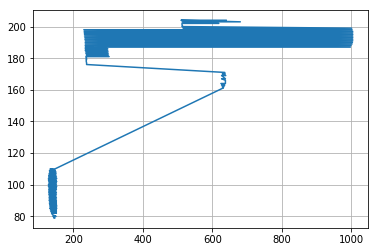

In [31]:
fig, ax = plt.subplots()
#s = pow(0.75,t)
ax.plot(indices[1][0:300],indices[0][0:300])
#ax.set(xlabel='time (s)', ylabel='voltage (mV)',
#       title='About as simple as it gets, folks')
ax.grid()

#fig.savefig("test.png")
plt.show()

In [32]:
print(str(indices[0][0:30])+','+str(indices[1][0:30]))

[79 79 79 79 80 80 80 80 80 80 81 82 82 82 82 82 83 83 83 84 84 85 85 85
 86 86 87 87 88 88],[144 145 146 147 141 142 143 148 149 150 140 137 138 139 147 151 135 136
 151 134 151 132 133 152 132 152 132 152 131 132]


In [33]:
tailleField = 3;#must be odd
nbPixelsAll = nbPixelField(indices[0], indices[1], frame, tailleField);
toto = nbPixelsAll > tailleField
sum(toto)

2110

In [34]:
nbPixelsAll

array([0., 0., 0., ..., 3., 2., 3.])

In [35]:
from numpy import pi
5-4*np.tan(np.arctan(-3/1))

17.0

In [36]:
13-4*np.tan(np.arctan(-2/3))

15.666666666666666

In [37]:
angleMat = fillAngleMat(7)

In [38]:
np.around(angleMat)

array([[-45., -34., -18.,   0.,  18.,  34.,  45.],
       [-56., -45., -27.,   0.,  27.,  45.,  56.],
       [-72., -63., -45.,   0.,  45.,  63.,  72.],
       [ 90.,  90.,  90.,   0.,  90.,  90.,  90.],
       [ 72.,  63.,  45.,  -0., -45., -63., -72.],
       [ 56.,  45.,  27.,  -0., -27., -45., -56.],
       [ 45.,  34.,  18.,  -0., -18., -34., -45.]])

In [39]:
posX=indices[0][257]
posY=indices[1][257]
titi = frame[int(posX - tailleField):int(posX + tailleField + 1),
                        int(posY - tailleField):int(posY + tailleField + 1)]/255

In [40]:
test = np.multiply(angleMat,titi)
test2 = test[np.nonzero(test)]
np.mean(test2)

60.0

In [41]:
test

array([[ -0.  ,  -0.  ,  -0.  ,   0.  ,   0.  ,   0.  ,   0.  ],
       [ -0.  ,  -0.  ,  -0.  ,   0.  ,   0.  ,   0.  ,   0.  ],
       [ -0.  ,  -0.  ,  -0.  ,   0.  ,   0.  ,   0.  ,   0.  ],
       [  0.  ,  90.  ,  90.  ,   0.  ,  90.  ,  90.  ,   0.  ],
       [ 71.57,   0.  ,   0.  ,  -0.  ,  -0.  ,  -0.  , -71.57],
       [  0.  ,   0.  ,   0.  ,  -0.  ,  -0.  ,  -0.  ,  -0.  ],
       [  0.  ,   0.  ,   0.  ,  -0.  ,  -0.  ,  -0.  ,  -0.  ]])

In [42]:
titi

array([[0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 1., 1., 1., 1., 0.],
       [1., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0.]])

In [43]:
255/(1+np.exp(0.1*(np.abs(np.std(test2))-30)))

13.02024160636719

In [44]:
sigmoidActivationFctN1(test2)

13.02024160636719

In [45]:
np.std(test2)

59.223488864920256

In [46]:
neuronList = np.zeros(1144,dtype=NeuronType)

In [47]:
neuronList

array([(0, 0., 0., 0., 0, 0, 0, 0), (0, 0., 0., 0., 0, 0, 0, 0),
       (0, 0., 0., 0., 0, 0, 0, 0), ..., (0, 0., 0., 0., 0, 0, 0, 0),
       (0, 0., 0., 0., 0, 0, 0, 0), (0, 0., 0., 0., 0, 0, 0, 0)],
      dtype=[('longueur', 'u1'), ('angle', '<f4'), ('weight', '<f4'), ('precision', '<f4'), ('xPos', 'u1'), ('yPos', '<u2'), ('group', 'u1'), ('layer', 'u1')])

In [48]:
neuronList.size

1144

In [49]:
neuronList[0].shape

()

In [50]:
pNeurons = pd.DataFrame(neuronList)

In [51]:
pNeurons.head()

,longueur,angle,weight,precision,xPos,yPos,group,layer
0,0,0.0,0.0,0.0,0,0,0,0
1,0,0.0,0.0,0.0,0,0,0,0
2,0,0.0,0.0,0.0,0,0,0,0
3,0,0.0,0.0,0.0,0,0,0,0
4,0,0.0,0.0,0.0,0,0,0,0


In [52]:
pNeurons['longueur'].head()

0    0
1    0
2    0
3    0
4    0
Name: longueur, dtype: uint8

In [53]:
pNeurons.loc[1:3,['angle','weight']]

,angle,weight
1,0.0,0.0
2,0.0,0.0
3,0.0,0.0


In [54]:
pNeurons.loc[1,['angle']]=28.34

In [55]:
pNeurons['longueur'] = tailleField

In [56]:
pNeurons.head()

,longueur,angle,weight,precision,xPos,yPos,group,layer
0,3,0.00,0.0,0.0,0,0,0,0
1,3,28.34,0.0,0.0,0,0,0,0
2,3,0.00,0.0,0.0,0,0,0,0
3,3,0.00,0.0,0.0,0,0,0,0
4,3,0.00,0.0,0.0,0,0,0,0


In [57]:
nbPixelsAll = nbPixelField(indices[0], indices[1], frame, tailleField)
lCriterion = nbPixelsAll > tailleField
print(lCriterion.shape)
print(len(indices[0]))
print(np.sum(lCriterion))
resultIndicesCriterionO = indices[0][lCriterion]
print(len(resultIndicesCriterionO))
resultIndicesCriterion1 = indices[1][lCriterion]
print(len(resultIndicesCriterion1))
print("result0 :")
print(np.min(resultIndicesCriterionO))
print(np.max(resultIndicesCriterionO))
print("result1 :")
print(np.min(resultIndicesCriterion1))
print(np.max(resultIndicesCriterion1))

(9219,)
9219
2110
2110
2110
result0 :
267
783
result1 :
41
1244


In [58]:
tailleField = 7
indices = np.where(frame != [0])
nbPixelsAll = nbPixelField(indices[0], indices[1], frame, tailleField)
print("indice 0")
print(np.min(indices[0]))
print(np.max(indices[0]))
print("indice 1")
print(np.min(indices[1]))
print(np.max(indices[1]))
titi = getNeuronActivationList(indices[0], indices[1], tailleField, frame,
                               nbPixelsAll)

indice 0
79
786
indice 1
40
1247
size :3500
newX
267
784
newY
40
1246

nb de positions couvertes : 3500 sur 3500


In [59]:
titi.describe()

,longueur,angle,weight,precision,xPos,yPos,group,layer
count,3500.0,3500.000000,3500.000000,3500.000000,3500.00000,3500.000000,3500.0,3500.0
mean,7.0,21.562643,112.191956,35.941238,440.72000,647.124000,0.0,1.0
std,0.0,34.081493,89.014671,21.144333,155.52692,328.170645,0.0,0.0
min,7.0,-60.000000,1.950733,0.000000,267.00000,40.000000,0.0,1.0
25%,7.0,-7.591429,21.004828,16.533459,318.00000,453.750000,0.0,1.0
50%,7.0,28.582292,106.523857,33.320559,382.00000,645.000000,0.0,1.0
75%,7.0,51.617293,202.363434,54.105482,545.00000,856.000000,0.0,1.0
max,7.0,87.367142,242.906403,78.653786,784.00000,1246.000000,0.0,1.0


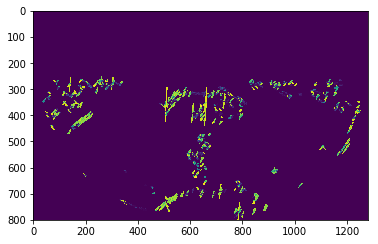

In [60]:
testBitmap = np.zeros(frame.shape)
testBitmap = drawFieldNeurons(titi, testBitmap)
imgplot = plt.imshow(testBitmap)

In [61]:
lintI = 0
while (lintI < 10):
    cv2.imshow('FRAME', frame)
    if cv2.waitKey(1) & 0xFF == ord('q'):  # press q to quit
        break
    lintI += 1

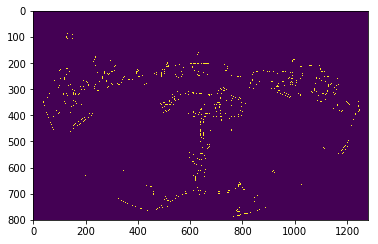

In [62]:
imgplot = plt.imshow(frame)

In [63]:
np.max(indices[0])

786

In [64]:
np.max(nbPixelsAll)

18.0

In [65]:
titi[0:4]

,longueur,angle,weight,precision,xPos,yPos,group,layer
0,7,0.352222,48.724552,44.430294,267,181,0,1
1,7,6.515000,20.340103,54.455429,267,182,0,1
2,7,-6.738000,18.484835,55.490616,267,190,0,1
3,7,-16.715000,29.620857,50.293053,267,191,0,1


In [66]:
moveCoordDeg(45,10,10,5)

(13.535533905932738, 6.464466094067262)

In [67]:
findGroups(titi);

In [68]:
titi[(titi.xPos > 779 - 3) & (titi.xPos < 779 + 3) & (titi.yPos > 799 - 3) &
     (titi.yPos < 799 + 3)]

,longueur,angle,weight,precision,xPos,yPos,group,layer
3482,7,65.592499,187.200836,19.843678,777,801,1626,1
3484,7,56.840000,190.779129,19.112120,778,799,1628,1
3485,7,59.967499,209.337494,14.773296,778,800,1629,1
3487,7,64.738571,198.459793,17.443655,779,798,1631,1
3488,7,59.472858,205.635635,15.731228,779,799,1632,1
3490,7,31.842501,12.486724,59.663906,780,797,1634,1
3491,7,38.571430,29.683374,50.269196,780,798,1635,1


In [69]:
titi.groupby('group').agg(['mean', 'count'])[0:5]

longueur            angle            weight        precision        \
          mean count       mean count        mean count       mean count   
group                                                                      
1            7     4  12.493855     4   24.812773     4  53.732510     4   
2            7     1 -16.715000     1   29.620857     1  50.293053     1   
3            7     1  -6.738000     1   18.484835     1  55.490616     1   
4            7     1 -30.000000     1  221.489014     1  11.115002     1   
5            7     2  27.360714     2  118.228043     2  33.455017     2   

        xPos         yPos       layer        
        mean count   mean count  mean count  
group                                        
1      268.0     4  182.0     4     1     4  
2      267.0     1  191.0     1     1     1  
3      267.0     1  190.0     1     1     1  
4      267.0     1  266.0     1     1     1  
5      268.0     2  279.5     2     1     2

In [70]:
closestFieldNeurons(titi, 779, 799, 3)

,longueur,angle,weight,precision,xPos,yPos,group,layer
3482,7,65.592499,187.200836,19.843678,777,801,1626,1
3484,7,56.840000,190.779129,19.112120,778,799,1628,1
3485,7,59.967499,209.337494,14.773296,778,800,1629,1
3487,7,64.738571,198.459793,17.443655,779,798,1631,1
3488,7,59.472858,205.635635,15.731228,779,799,1632,1
3490,7,31.842501,12.486724,59.663906,780,797,1634,1
3491,7,38.571430,29.683374,50.269196,780,798,1635,1


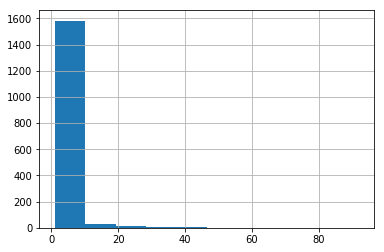

In [71]:
titi.groupby('group').size().hist()

In [72]:
resultGroup = titi.groupby('group').size()

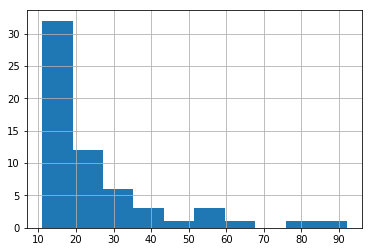

In [73]:
resultGroup[resultGroup>10].hist()

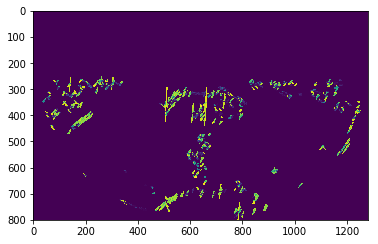

In [74]:
testBitmap = np.zeros(frame.shape)
testBitmap = drawFieldNeurons(titi, testBitmap)
imgplot = plt.imshow(testBitmap)

In [75]:
lintI = 0
while (lintI < 10):
    cv2.imshow('TEST BITMAP', testBitmap)
    if cv2.waitKey(1) & 0xFF == ord('q'):  # press q to quit
        break
    lintI += 1

In [76]:
titi.describe()

,longueur,angle,weight,precision,xPos,yPos,group,layer
count,3500.0,3500.000000,3500.000000,3500.000000,3500.00000,3500.000000,3500.000000,3500.0
mean,7.0,21.562643,112.191956,35.941238,440.72000,647.124000,813.410286,1.0
std,0.0,34.081493,89.014671,21.144333,155.52692,328.170645,479.926720,0.0
min,7.0,-60.000000,1.950733,0.000000,267.00000,40.000000,1.000000,1.0
25%,7.0,-7.591429,21.004828,16.533459,318.00000,453.750000,392.000000,1.0
50%,7.0,28.582292,106.523857,33.320559,382.00000,645.000000,838.000000,1.0
75%,7.0,51.617293,202.363434,54.105482,545.00000,856.000000,1214.250000,1.0
max,7.0,87.367142,242.906403,78.653786,784.00000,1246.000000,1643.000000,1.0
